# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from backgrad_utils import *
from mxnet.gluon.data.dataset import ArrayDataset

ctx = mx.gpu(0)
ArrayDataset_dir = arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label

_origin_data_array, _origin_label_array = None, None
def data_loader2(batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2], origin_shuffle=False):
    global _origin_data_array, _origin_label_array
    if _origin_data_array is None:
        _origin_data_array, _origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_data_array, origin_label_array = _origin_data_array, _origin_label_array
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform[0])
    origin_data = gluon.data.DataLoader(origin_ds, batch_size[0], shuffle=origin_shuffle, last_batch='keep', num_workers=num_workers[0])
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform[1])
    train_data = gluon.data.DataLoader(train_ds, batch_size[1], shuffle=True, last_batch='keep', num_workers=num_workers[1])
    
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform[2])
    test_data = gluon.data.DataLoader(test_ds, batch_size[2], shuffle=False, last_batch='keep', num_workers=num_workers[2])
    return (origin_data, train_data, test_data), (origin_ds, train_ds, test_ds)

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [3]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [4]:
import utils
import os, shutil
%matplotlib inline

EPS = 1e-30

def show_data(data, clip=True):
    images = inv_normalize(data, clip=clip)
    show_images(images, clip=clip)
    
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)
   
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
    
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    return t
    
def inv_normalize(data, mean=None, std=None, clip=True, asnumpy=True):
    if mean is None: mean=nd.array([0.4914, 0.4822, 0.4465])
    if std is None: std=nd.array([0.2023, 0.1994, 0.2010])
    if asnumpy: 
        data, mean, std = data.asnumpy(), mean.asnumpy(), std.asnumpy()
    images = data.transpose((0, 2, 3, 1))
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images

mean=nd.array([0.4914, 0.4822, 0.4465])
std=nd.array([0.2023, 0.1994, 0.2010])
threshold = (nd.array([[0, 0, 0], [1, 1, 1]]) - mean) / std

class BackGradDataGenerator:
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, sgd=None, threshold=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
#         if str(context)[:3] != "cpu":
#             print "warring: data was not in CPU, the returned backgrad_data is shallow copy of data."
        if bn_control is not None:
            bn_control.store()
        if sgd is None:
            sgd = BackGradDataGenerator.SGD

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        for iters in range(1, max_iters+1):
            with autograd.record():
                data.attach_grad()
                output = net(data)
                loss = -loss_f(output, label)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()     # reduce will make memory release

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss

            sgd(data, lr)
        if threshold is not None:
            for i in range(3):
                data[:, i, :, :] = data[:, i, :, :].clip(threshold[0, i].asscalar(), threshold[1, i].asscalar())
        if bn_control is not None:
            bn_control.load()
            
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
    
    @staticmethod
    def MSE_constraint(mse, same_rate=False):
        def constraint(backgrad_data, data, diff, _loss, MSE, SNR):
            if same_rate:
                rate = nd.mean(nd.sqrt(mse / MSE))
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data) * rate)
            else:
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data).transpose((1, 2, 3, 0))
                                                * (nd.sqrt(mse / MSE))).transpose((3, 0, 1, 2))
        return constraint
    
    @staticmethod
    def generate_backgrad_data_constraint(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, post_deal=None, 
                                          sgd=None, threshold=None):
        backgrad_data = data.as_in_context(mx.cpu()) if post_deal is not None else data
        backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data(net, backgrad_data, label, 
                                            max_iters, lr, iter_log, clip, loss_f, bn_control, sgd, None)
        
        
        if post_deal is not None:
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            post_deal(backgrad_data, data, diff, _loss, MSE, SNR)
            
        if threshold is not None:
            for i in range(3):
                backgrad_data[:, i, :, :] = backgrad_data[:, i, :, :].clip(threshold[0, i].asscalar(), threshold[1, i].asscalar())
                
        return backgrad_data, (_loss, _bloss, ) 
            
    @staticmethod
    def generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,
                            use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                            loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=None, begin_index=0, 
                            bn_control=None, post_deal=None, sgd=None, threshold=None):
        out_idx, iters = begin_index, 0
        diffs, losses, MSEs, SNRs, bloss = None, None, None, None, 0
        
        if bn_control is None:
            bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
            bn_backup.store()
        for data, label in origin_data:
            backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data_constraint(
                net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f, 
                bn_control=bn_control, post_deal=post_deal, sgd=sgd, threshold=threshold)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            if sgd is not None or post_deal is not None: # new change get new loss
                _loss = loss_f(net(backgrad_data.as_in_context(ctx)), label.as_in_context(ctx))
                _bloss = nd.mean(_loss).asscalar()
            bloss += _bloss

            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
                
            # must copy to cpu, or will make gpu memory leak(not release)
            backgrad_data = inv_normalize(backgrad_data, clip=False, asnumpy=False)
            out_data[out_idx:out_idx+data.shape[0], :, :, :] = backgrad_data.transpose((0, 2, 3, 1)).as_in_context(mx.cpu())
            out_idx += data.shape[0]
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False), clip=False)
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy(), clip=False)
            iters += 1
        if bn_control is None:
            bn_backup.load()
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs    
        
BGG = BackGradDataGenerator

## 3.2 view result

# 4. generate Folderdataset File

In [5]:
from mxnet import nd
from time import time
import os
label_text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
data_count = {}
root_dir = "/home/hui/dataset/CIFAR10/"
def save_data(data, label, root_dir):
    data = data.transpose((0, 2, 3, 1))
    for i in range(data.shape[0]):
        l = label_text[int(label[i].asscalar())]
        name = os.path.join(root_dir, l)
        if not data_count.has_key(l):
            mkdir_if_not_exist([name])
            data_count[l] = 0
        name = os.path.join(root_dir, l, str(data_count[l])+'.ndarray')
        nd.save(name, data[i])
        data_count[l] += 1

## 4.1 generate origin data

iter: 0 time: 0.120635986328


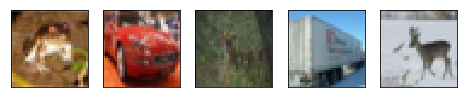

iter: 500 time: 5.95371294022


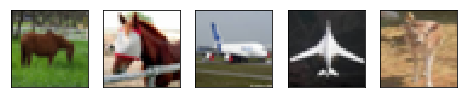

iter: 1000 time: 11.6519799232


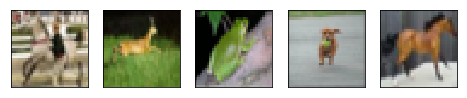

iter: 1500 time: 17.1694579124


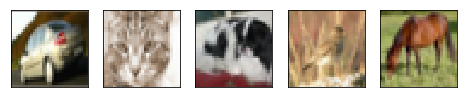

In [12]:
def save_train_origin_data(root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    
    cur_time, iters = time(), 0
    for data, label in train_data:
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        
        if iters % 500 == 0:
            print 'iter:', iters, 'time:', time() - cur_time
            show_images(data[range(0, 25, 5)], clip=False)
        iters += 1

data_count = {}
save_train_origin_data(root_dir + "origin/")

## 4.4 generate test data

iter: 0 time: 0.0692410469055


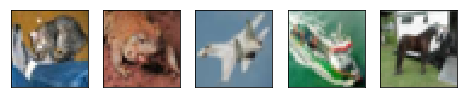

iter: 100 time: 1.35200309753


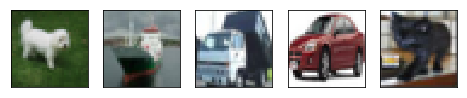

iter: 200 time: 2.60023403168


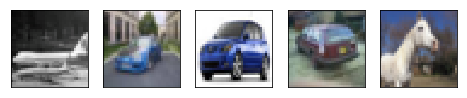

iter: 300 time: 4.03572487831


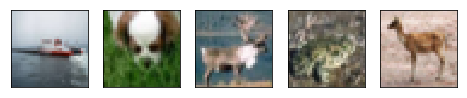

In [19]:
def save_train_origin_data(root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    
    cur_time, iters = time(), 0
    for data, label in train_data:
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        
        if iters % 100 == 0:
            print 'iter:', iters, 'time:', time() - cur_time
            show_images(data[range(0, 25, 5)], clip=False)
        iters += 1

data_count = {}
save_train_origin_data(root_dir + "test/")

## 4.2 generate backgrad image iter10

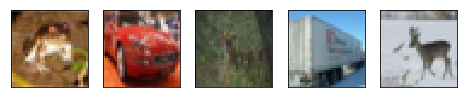

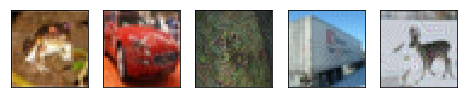

iter: 0 time: 0.826164007187 loss: -13.5021


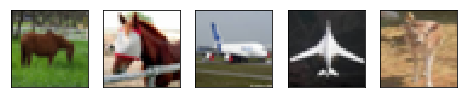

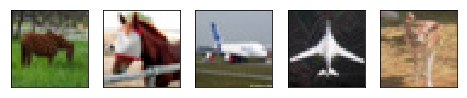

iter: 500 time: 87.5653541088 loss: -12.0789


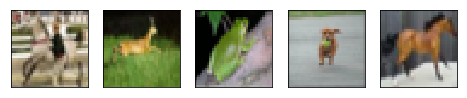

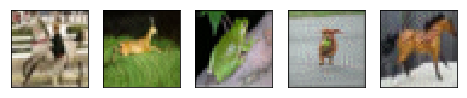

iter: 1000 time: 172.665369987 loss: -16.0794


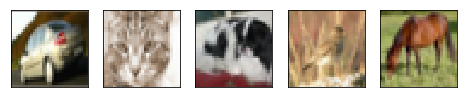

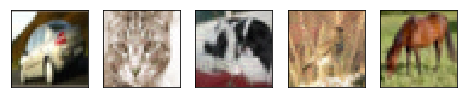

iter: 1500 time: 267.36185503 loss: -16.7082
-15.2065354594


In [13]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
root_dir2 = root_dir + '/backgrad/resnet18_me_200e_iter10'

def save_train_backgrad_data(net, root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)

    cur_time, iters, loss = time(), 0, 0.
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False), clip=False)
        
        data, (_loss, ) = generate_backgrad_data(
            net, data, label, max_iters=10, lr=0.1, iter_log=False, clip=False)
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)], clip=False)
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    return loss

data_count = {}
mean_loss = save_train_backgrad_data(net, root_dir2)
print mean_loss

## 4.3 generate backgrad image iter15

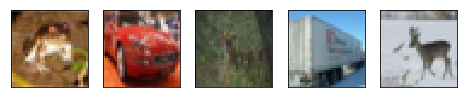

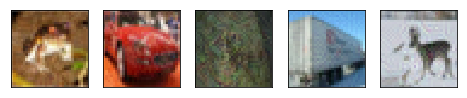

iter: 0 time: 0.777281045914 loss: -24.4299


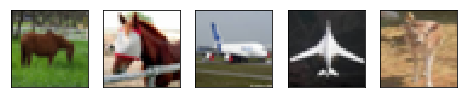

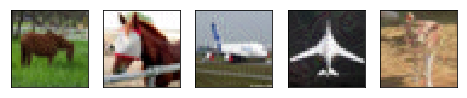

iter: 500 time: 133.815998077 loss: -21.3442


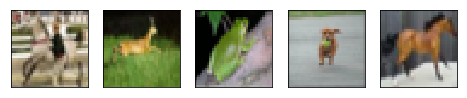

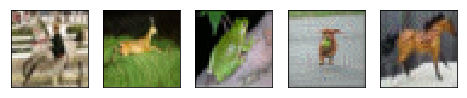

iter: 1000 time: 274.85204792 loss: -24.6436


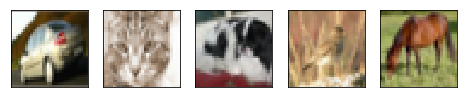

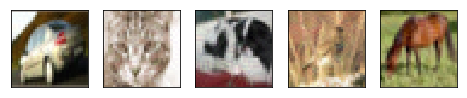

iter: 1500 time: 403.243082047 loss: -24.7234
-23.075851618


In [14]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
root_dir2 = root_dir + '/backgrad/resnet18_me_200e_iter15'

def save_train_backgrad_data(net, root_dir):
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)

    cur_time, iters, loss = time(), 0, 0.
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False))
        
        data, (_loss, ) = generate_backgrad_data(
            net, data, label, max_iters=15, lr=0.1, iter_log=False, clip=False)
        data = inv_normalize(data, clip=False)
        save_data(nd.array(data), label, root_dir)
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)], clip=False)
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    return loss

data_count = {}
mean_loss = save_train_backgrad_data(net, root_dir2)
print mean_loss

# 5. generate ArrayDaset File

## 5.1 turn Folder dataset file to ArrayDataset file

In [20]:
from dataset import *
from cifar10_utils import show_images
ArrayDataset_dir = root_dir + "/arraydataset/"
mkdir_if_not_exist([ArrayDataset_dir])

def turn_folder_to_array_ds(folder_roots, array_path):
    train_ds = MultiFolderDataset(folder_roots, transform=None)  # or use NDArrayFileDataset
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    cur_time, iters = time(), 0
    all_data, all_label, iters = None, None, 0
    for data, label in train_data:
        if all_data is None:
            all_data = data
            all_label = label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
            
        if iters % 500 == 0:
            print 'iter:', iters, 'time:', time() - cur_time
        iters += 1
    nd.save(array_path, [all_data, all_label])

In [8]:
turn_folder_to_array_ds([root_dir + '/origin/'], ArrayDataset_dir + "/origin.ndarray")

iter: 0 time: 1.44049096107
iter: 500 time: 161.650902987
iter: 1000 time: 312.603041887
iter: 1500 time: 450.819705009


In [21]:
turn_folder_to_array_ds([root_dir + '/test/'], ArrayDataset_dir + "/test.ndarray")

iter: 0 time: 0.0412368774414


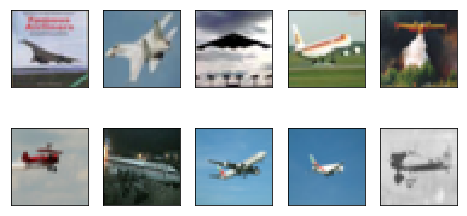

In [22]:
from dataset import MyArrayDataset
def data_loader_for_array_ds(array_file):
    datas, labels = nd.load(array_file)
    train_ds = MyArrayDataset([datas, labels], transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    return train_data

train_data = data_loader_for_array_ds(ArrayDataset_dir + "/test.ndarray")
for data, label in train_data:
    show_images(inv_normalize(data[:10, :, :, :]), clip=False)
    break

## 5.2 generate backgrad array dataset directly

In [12]:
from time import time

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def save_train_backgrad_data_as_arraydataset(net, save_path, max_iters=10, lr=0.1, use_batch_mean_std=True, 
                                             post_deal=None, sgd=None, threshold=None):
    train_ds = MyArrayDataset(load_all_data_label(pathes=['/home/hui/dataset/CIFAR10/arraydataset/origin.ndarray']),
                              transform=_transform_test)
    # train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
    
    cur_time, iters, loss = time(), 0, 0.
    all_data, all_label, iters = None, None, 0
    bn_control = BNControl(net.net, use_batch_mean_std)
    for data, label in train_data:
        if iters % 500 == 0:
            show_images(inv_normalize(data[range(0, 25, 5)], clip=False), clip=False)
        
#         data, (_loss, ) = generate_backgrad_data(
#             net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False)
        data, (_, _loss) = BGG.generate_backgrad_data_constraint(net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=bn_control, post_deal=post_deal, 
                                          sgd=sgd, threshold=threshold)
        data = nd.array(inv_normalize(data, clip=False))
        
        if all_data is None:
            all_data = data
            all_label = label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
        
        if iters % 500 == 0:
            show_images(data[range(0, 25, 5)].asnumpy(), clip=False)
            print 'iter:', iters, 'time:', time() - cur_time, 'loss:', _loss
        iters += 1
        loss += _loss
    loss /= len(train_data)
    nd.save(save_path, [all_data.transpose((0, 2, 3, 1)), all_label.astype('int64')])
    return loss

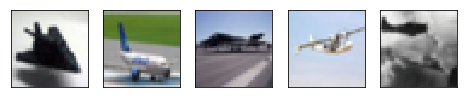

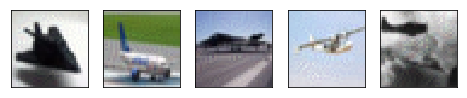

iter: 0 time: 0.976181983948 loss: -21.0749


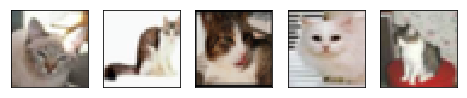

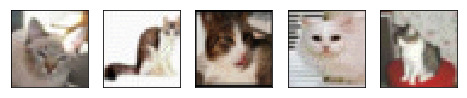

iter: 500 time: 87.8764359951 loss: -20.1489


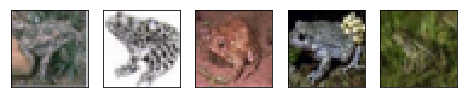

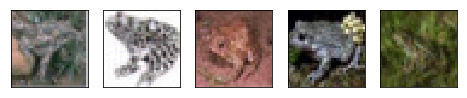

iter: 1000 time: 192.60353899 loss: -21.0462


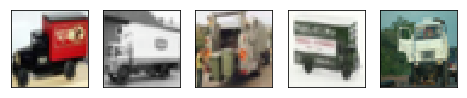

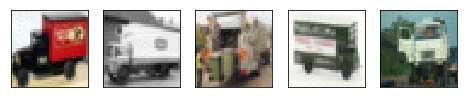

iter: 1500 time: 315.849364042 loss: -20.2354


-20.513444267170442

In [11]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
save_train_backgrad_data_as_arraydataset(net, ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10.ndarray",
                                         10, 0.1)

In [ ]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label(pathes=[ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10.ndarray"]),
                              transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
print utils.evaluate_accuracy(train_data, net, ctx)

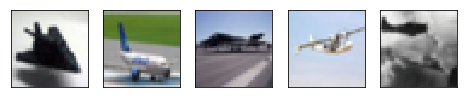

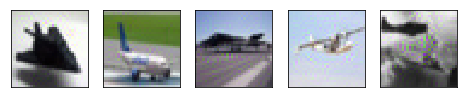

iter: 0 time: 1.14436101913 loss: -18.0765


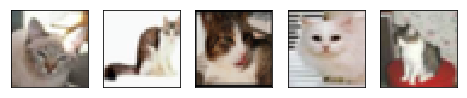

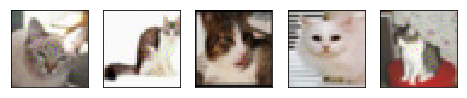

iter: 500 time: 90.6565229893 loss: -17.3003


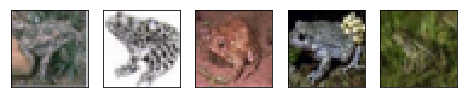

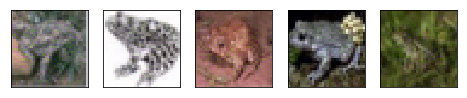

iter: 1000 time: 202.207072973 loss: -18.2011


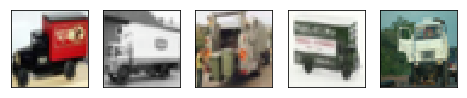

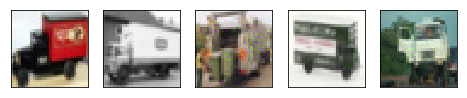

iter: 1500 time: 347.102571011 loss: -18.7332


-17.889238380119728

In [9]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad_iter10", ctx=ctx)
save_train_backgrad_data_as_arraydataset(net, ArrayDataset_dir + "/backgrad_resnet18_me_200e_backgrad_iter10_iter10.ndarray",
                                         10, 0.1)

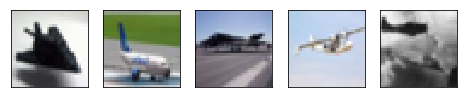

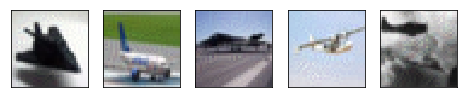

iter: 0 time: 0.882794141769 loss: -21.0712


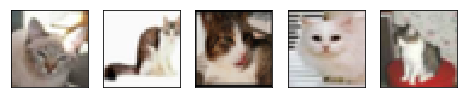

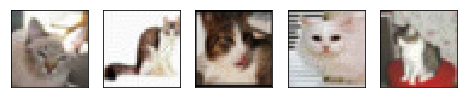

iter: 500 time: 107.70522213 loss: -20.156


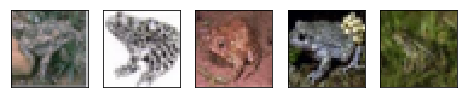

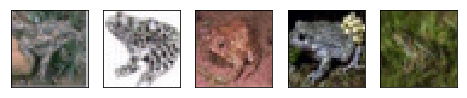

iter: 1000 time: 278.253517151 loss: -21.043


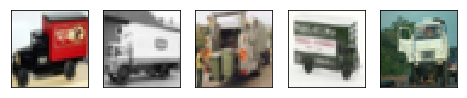

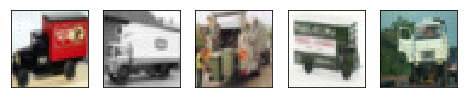

iter: 1500 time: 507.091298103 loss: -20.2402
0.324196257198


In [13]:
net = ResNet(10)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
save_train_backgrad_data_as_arraydataset(net, ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10_clip.ndarray",
                                         10, 0.1, post_deal=None, sgd=None, threshold=threshold)
train_ds = MyArrayDataset(load_all_data_label(pathes=[ArrayDataset_dir + "/backgrad_resnet18_me_200e_iter10_clip.ndarray"]),
                              transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, last_batch='keep', num_workers=4)
print utils.evaluate_accuracy(train_data, net, ctx)

# 6. image viwer

In [6]:
def turnnd2np(path):
    data, label = load_all_data_label(pathes=[ArrayDataset_dir + "/" + path + ".ndarray"])
    np.save(ArrayDataset_dir + 'npy/'+ path +'_data', data.asnumpy())
    np.save(ArrayDataset_dir + 'npy/'+ path + '_label', label.asnumpy())

In [7]:
turnnd2np('backgrad_resnet18_me_200e_iter10_clip')
turnnd2np('origin')

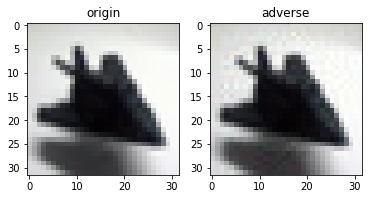

In [4]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
def load_all_np_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = np.load(path + "_data.npy"), np.load(path + "_label.npy")
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = np.concatenate([all_data, data], dim=0)
            all_label = nd.concatenate([all_label, label], dim=0)
    return all_data, all_label

adverse_data, adverse_label = load_all_np_data_label(['/home/hui/dataset/CIFAR10/arraydataset/npy/backgrad_resnet18_me_200e_iter10_clip'])
origin_data, adverse_label = load_all_np_data_label(['/home/hui/dataset/CIFAR10/arraydataset/npy/origin'])
plt.subplot(121)
plt.imshow(origin_data[0] / 255)
plt.title('origin')
plt.subplot(122)
plt.title('adverse')
plt.imshow(adverse_data[0] / 255)

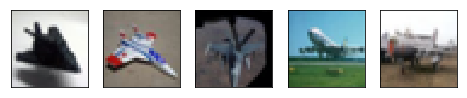

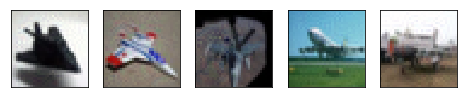

In [9]:
import sys
sys.path.insert(0, '../../utils')
from cifar10_utils import show_images
show_images(origin_data[0:5].transpose((0, 3, 1, 2)), clip=False)
show_images(adverse_data[0:5].transpose((0, 3, 1, 2)), clip=False)